# Exploration of ARIMA modeling

In this notebook, we take a more rigorous look at various formulations of ARIMA models, and compare them to a baseline of a trended persistance forecast. It's not looking good for ARIMA.

In [1]:
from core.problems import SumToSumARIMA
from core.preprocessing import make_small_train, make_small_dev
from core.utilities import plot_forecasts, calc_test_mse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')
from time import time

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_pickle('data/detrended_master_dataset.pkl').fillna(0)
clearsky_df = pd.read_pickle('data/clearsky_master_dataset.pkl').fillna(0)
train_df = make_small_train(df, 'combined')
test_df = make_small_dev(df)
test_clearsky = make_small_dev(clearsky_df)

In [3]:
prob = SumToSumARIMA(train_df)

### A grid parameter search

Let's start by exploring some of the AR and MA parameter space. $p$ is the AR parametet (How many previous terms are used in the model) and $q$ is the MA term (the number of lagged error terms).

In [4]:
ps = [2, 12, 18, 24, 30]
qs = [0, 1, 2]
for p in ps:
    for q in qs:
        prob.train(order=(p,0,q))
        prob.test(test_df['total_power'])
        forecasts = prob.forecasts
        transformed_forecasts = [(clearsky_df['total_power'] - f).dropna() for f in forecasts]
        mse = calc_test_mse((clearsky_df['total_power'] - test_df['total_power']).dropna(), transformed_forecasts)
        print 'p: {}, q: {}, error: {:.3f}'.format(p, q, mse)

p: 2, q: 0, error: 1196.860
p: 2, q: 1, error: 1170.691
p: 2, q: 2, error: 1131.697


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 12, q: 0, error: 1111.234


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 12, q: 1, error: 1113.995


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 12, q: 2, error: 1117.068
p: 18, q: 0, error: 1114.631
p: 18, q: 1, error: 1121.366


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 18, q: 2, error: 1116.282
p: 24, q: 0, error: 1035.902
p: 24, q: 1, error: 1032.423
p: 24, q: 2, error: 1033.442
p: 30, q: 0, error: 1006.387


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 30, q: 1, error: 1006.629


/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p: 30, q: 2, error: 1006.377


#### Best run:

Our best run used parameters:

- p = 24
- q = 1

Here's what the predictions looked like:

883.455207069


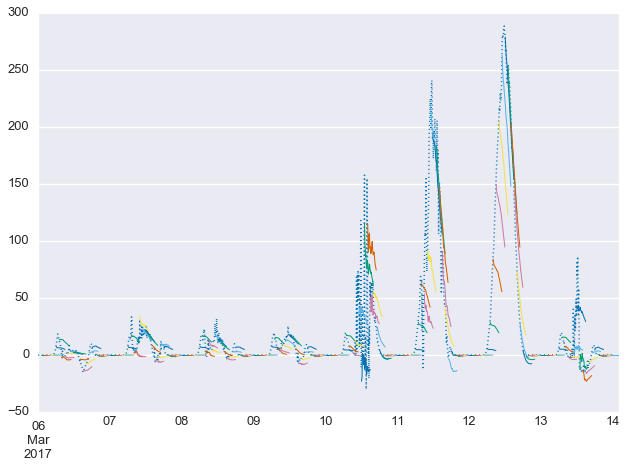

In [5]:
prob.train(order=(30,0,0))
prob.test(test_df['total_power'])
print prob.calc_mse()
prob.plot_test()

Now lets try a couple higher orders of $d$, the integral term. The differencing step deals with non-stationary data. We don't have that here—the data is approximately stationary—but let's try anyway.

In [6]:
for d in [0, 1, 2]:
    prob.train(order=(30,d,0))
    prob.test(test_df['total_power'])
    print 'd: {}, error: {:.3f}'.format(d, prob.calc_mse())

d: 0, error: 883.455
d: 1, error: 1096.569
d: 2, error: 1596.413


This does not help, if we inspect the $d=2$ run, we can see why:

5872.09090229


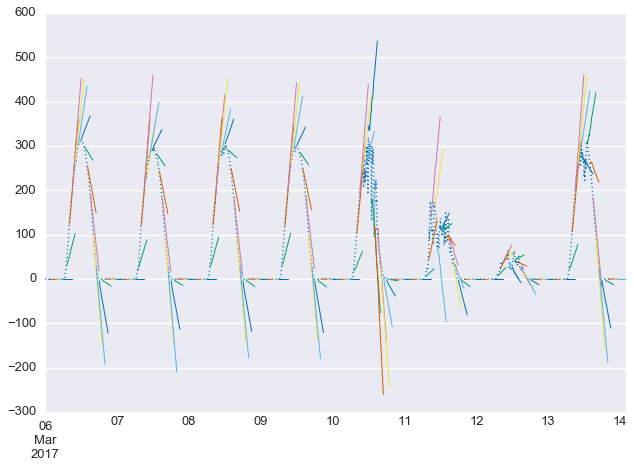

In [8]:
prob.train(order=(24, 2, 0))
prob.test(test_df['total_power'])
print prob.calc_mse()
prob.plot_test()

Increasing the integral term gives the model a lot of "momentum" causing the forecast to tend to continue on the trajectory from the previous data.

### Other notes

- I tried a few other solvers, and didn't get any significantly different or better results. A couple of the solvers didn't converge at all.
- There are also seasonal parameters and exogenous parameters that can be included in the model. I did a bit of testing with both and couldn't get any improvement